# Basic Tutorial - NMC-style utility models, 1D design domain
In this tutorial, we will walk through the main steps to define your own forward model ensemble, optimize the ACV structure of the MF-EIG estimator, then evaluate the MF-EIG estimator. It is expected that MXMCPy and its dependencies are already installed. Note that individual results may differ depending on one's random seed.

In [1]:
# install necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import warnings

# MXMCPy utilities
from mxmc import Optimizer
from mxmc import Estimator
from mxmc import OutputProcessor

## Step 1: Define multi-fidelity model ensemble
First we must define our ensemble forward models and package them into a Python list, whose first entry is the high-fidelity model and so on. The following definitions must also be made: `n_param` for the dimension of the parameter space $\Theta$, `n_models` for the total number of models (including the high-fidelity model).

In [2]:
def g0(theta, d):
    first_term = theta**3*d**2
    second_term = theta*np.exp(-1*np.abs(0.2-d))
    return first_term + second_term

def g1(theta, d):
    first_term = (0.5**0.5)*(1.**0.25)*theta**2.5*d**1.75
    second_term = theta*np.exp(-1*np.abs(0.2-d))
    return first_term + second_term

def g2(theta, d):
    first_term = 0.5*(1.**0.5)*theta**2*d**1.5
    second_term = theta*np.exp(-1*np.abs(0.2-d))
    return first_term + second_term

model_ensemble = [g0, g1, g2]
model_costs = np.array([1., 0.1, 0.01])
n_models = len(model_ensemble)
n_param = 1

## Step 2: Define OED problem parameters and functions
Next, we must define the OED problem, including the design domain ($\Xi$) bounds (`lb` and `ub`) and the prior distribution on $\Theta$ and its distribution's parameters (in this case we define a uniform distribution with parameters `lb_theta` and `ub_theta`). 

We also need to define some utilities for OED, including functions to sample from the prior, to sample from the noise (here assumed to be additive noise as represented by the data model  $y=g(\theta,\xi)+\epsilon$ ), and to evaluate the logpdf of the noise term. 

Lastly, choose some parameters of the MF-EIG estimator: we set the `reuse` parameter, which will bolster utility model correlations if set to `True` and will allow random inner-loop sampling if set to `False`; and we set `n_in` as a list of inner-loop sample sizes (the naive implementation is used here).

In [3]:
# design domain
lb = 0
ub = 1

# prior distribution on theta
lb_theta = 0
ub_theta = 1

# noise distribution
eps_std = 1e-1

# NMC parameters
reuse = True
n_in = [2500, 2500, 2500]

# define OED utility functions
def sample_prior(n_sample, n_param, lb, ub, seed=3142):   
    np.random.seed(seed)
    thetas = np.random.uniform(lb, ub, (n_sample, n_param))
    return thetas

def sample_epsilon(n_samples, mean=0, sd=1e-1, seed=3141):
    # note: sd is standard deviation of Gaussian noise term 
    np.random.seed(seed)
    epsilons = np.random.normal(mean,sd,n_samples)
    epsilons = np.reshape(epsilons,(-1,1))
    return epsilons

def evaluate_log_epsilon(epsilon, mean=0, sd=1e-1):
    eps_pdf = st.norm.logpdf(epsilon,mean,sd)
    return eps_pdf

## Step 3: Define NMC utility models/functions
We will define the NMC-style utility function below. This is a direct application of Equation 32 from the paper:
$$ u_{m}(\xi,z^{(i)}) = \log{\left[ \frac{p(\epsilon^{(i)} |\xi)} { \frac{1}{N_{\text{in},m}} \sum_{j=1}^{N_{\text{in},m}} p_{\epsilon|\xi}\left( g_{m}(\theta^{(i)},\xi) +\epsilon^{(i)} -  g_{m}(\tilde{\theta}^{(i,j)},\xi) \big| \xi \right)} \right]}. $$

In [4]:
def eig_eps_fast_vec(epsilons, n_out, n_in, g_inner, g_outer):
    u_d = np.empty((n_out,))
    u=0
    for i in range(n_out):
        eps_log_pdf = evaluate_log_epsilon(epsilons[i])
            
        eps_inners=g_outer[i]+epsilons[i]-g_inner
        evidence=np.exp(evaluate_log_epsilon(eps_inners))
        evidence=np.sum(evidence)/n_in
        u+=eps_log_pdf - np.log(evidence)
        
        u_d[i]=u
        u=0
    return u_d

## Step 4: Perform pilot sampling
In order to choose an optimal set of ACV estimator hyperparameters for the MF-EIG estimator, we must first estimate the covariance matrix between model outputs. We use a domain-averaged covariance matrix over `n_intervals` intervals across the design domain.

In [5]:
# define and construct array of utility model pilot sample evaluations
n_intervals = 40
n_pilot_per_interval = 200
d_intervals = np.linspace(lb,ub,n_intervals)
test_size = n_intervals * n_pilot_per_interval
d_pilot = np.zeros((test_size,))
for j in range(n_intervals):
    d_pilot[j*n_pilot_per_interval:(j+1)*n_pilot_per_interval] = d_intervals[j]*np.ones((n_pilot_per_interval,))
y_pilot = np.zeros((n_models, test_size))

# draw outer-loop pilot samples of Z
thetas_pilot = sample_prior(test_size, n_param, lb_theta, ub_theta).flatten()
eps_pilot = sample_epsilon(test_size)

# evaluate utility models
for level in range(n_models):
    g = model_ensemble[level]
    g_outer = g(thetas_pilot,d_pilot)
    if reuse:
        thetas_inner = sample_prior(int(n_in[level]), n_param, lb_theta, ub_theta).flatten()
        for ii in range(test_size):
            g_inner  = g(thetas_inner.flatten(),d_pilot[ii])
        y_pilot[level,:] = eig_eps_fast_vec(eps_pilot, test_size, n_in[level], g_inner, g_outer)
    else:
        # fresh inner-loop sampling
        for ii in range(test_size):
            thetas_inner = sample_prior(int(n_in[level]), n_param, lb_theta, ub_theta,seed=ii+level*test_size)
            g_inner  = g(thetas_inner.flatten(),d_pilot[ii])
            y_pilot[level, ii] = ute.eig_eps_fast(eps_pilot[ii],1,int(n_in[level]),g_inner,np.array(g_outer[ii],ndmin=1))

# compute design-averaged covariance
covs_all = np.zeros((n_models,n_models,n_intervals))
for j in range(n_intervals):
    covs_all[:,:,j] = np.cov(y_pilot[:,j*n_pilot_per_interval:(j+1)*n_pilot_per_interval])
cov_test = np.average(covs_all,axis=2)
print(cov_test)

/var/folders/2s/v7k94jxx485g3_436vqk_zj80000gr/T/ipykernel_89757/1129320999.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_d[i]=u


[[0.66008822 0.6144917  0.57967959]
 [0.6144917  0.5833417  0.56094484]
 [0.57967959 0.56094484 0.59826049]]


## Step 5: Set optimal MF-EIG estimator ACV hyperparameters
Now, given a budget `target_cost` for each MF-EIG evaluation, we compute our utility model costs vector and use the MXMCPy tool to set the optimal sample allocation and weights vector, as saved in the `sample_allocation` and `estimator` variables.

In [6]:
target_cost = 1e6
w = model_costs * (np.array(n_in) + 1)
n_nmc_sf = int(np.ceil(target_cost/w[0]))
var_sf = cov_test[0,0]/n_nmc_sf
print("Single-fidelity NMC variance: ",var_sf)

variance_results = dict()
sample_allocation_results = dict()        
mxmc_optimizer = Optimizer(w, np.transpose(cov_test))        
algorithms = Optimizer.get_algorithm_names()
for algorithm in algorithms:        
    opt_result = mxmc_optimizer.optimize(algorithm, target_cost)
    variance_results[algorithm] = opt_result.variance
    sample_allocation_results[algorithm] = opt_result.allocation        
    print("{} method variance: {}".format(algorithm, opt_result.variance))        
best_method = min(variance_results, key=variance_results.get)
sample_allocation = sample_allocation_results[best_method]        
print("\nBest method and projected variance: ", best_method,f"{opt_result.variance:.5e}")
print("Compared to single-fidelity projected variance: ", f"{var_sf:.5e}")
print("Variance reduction ratio: ", f"{var_sf/opt_result.variance:.5f}")
print("\nSample allocation to each model: ", sample_allocation.get_number_of_samples_per_model())
mf_eig_estimator = Estimator(sample_allocation, cov_test)

Single-fidelity NMC variance:  0.0016502205410073598
mfmc method variance: [0.00019695]
mlmc method variance: [0.00020245]
acvmfu method variance: 0.00040923046547180364
acvmf method variance: 0.00040923046547180364
acvmfmc method variance: 0.00019695390744395302
acvkl method variance: 0.00019695390744395302
gmfsr method variance: 0.00019695390744395302
gmfmr method variance: 0.00019695390744395302
acvis method variance: 0.0003314502604388051
gissr method variance: 0.00018649893565279935
gismr method variance: 0.00018649893565279935
wrdiff method variance: 0.00018649893565279935
grdsr method variance: 0.00018649893565279935
grdmr method variance: 0.00018649893565279935

Best method and projected variance:  gissr 1.86499e-04
Compared to single-fidelity projected variance:  1.65022e-03
Variance reduction ratio:  8.84842

Sample allocation to each model:  [  160  1298 10902]


## Step 6: Perform MF-EIG estimation across domain
We can now use the `mf_eig_estimator` object to perform multi-fidelity estimation across the domain.

In [7]:
n_d=40
d_vals = np.linspace(lb, ub, n_d+1)
u_d = np.zeros((n_d+1,))
u_d_nmc = np.zeros((n_d+1,))
dcount = 0
seed = int(0)
print("Computing MF-EIG for:")
for d in d_vals:
    print("d = ",f"{d:.3f}")

    #  allocating samples
    total_samples = sample_allocation.num_total_samples
    epsilons_all = sample_epsilon(total_samples)
    thetas_all = sample_prior(total_samples, n_param, lb_theta, ub_theta, seed=seed)
    thetas_inner_all = sample_prior(int(np.max(n_in)), n_param, lb_theta, ub_theta, seed=seed)
    epsilons_allocated = sample_allocation.allocate_samples_to_models(epsilons_all)
    thetas_allocated = sample_allocation.allocate_samples_to_models(thetas_all)
    
    #  evaluating models for above samples
    model_outputs = list()
    level=0
    for theta_sample, epsilon_sample, model in zip(thetas_allocated, epsilons_allocated, model_ensemble):
        n_samples = len(theta_sample)
        if reuse:
            if n_samples >= n_in[level]:
                thetas_inner = np.vstack((thetas_inner_all,
                                          sample_prior(int(n_samples-n_in[level]), n_param, lb_theta, ub_theta,seed=ii+level*(n_d+1))))
            else:
                thetas_inner = thetas_inner_all[:n_in[level]]
        else:
            thetas_inner = sample_prior(int(n_in[level]), n_param, lb_theta, ub_theta,seed=ii+level*(n_d+1))
        
        g_outer = model(theta_sample,d)
        g_inner = model(thetas_inner,d)
        eig_outputs = eig_eps_fast_vec(epsilon_sample,n_samples,n_in[level],g_inner,g_outer)
        model_outputs.append(eig_outputs)
        level += 1

    #  forming and evaluating estimator
    u_d[dcount] = mf_eig_estimator.get_estimate(model_outputs)

    # also compute an oracle sf NMC estimate
    n_oracle = int(1e5)
    thetas_outer_DNMC = sample_prior(n_oracle, n_param, lb_theta, ub_theta, seed=seed)
    thetas_inner_DNMC = thetas_inner_all[:n_in[0]]
    eps_outer_DNMC = sample_epsilon(n_oracle, seed=seed)
    g_outer_DNMC = model_ensemble[0](thetas_outer_DNMC,d)
    g_inner_DNMC = model_ensemble[0](thetas_inner_DNMC,d)
    u_d_nmc[dcount] = eig_eps_fast_vec(eps_outer_DNMC,n_nmc_sf,n_in[0],g_inner_DNMC,g_outer_DNMC).mean()   

    # iterate dcount
    dcount += 1

Computing MF-EIG for:
d =  0.000


/var/folders/2s/v7k94jxx485g3_436vqk_zj80000gr/T/ipykernel_89757/1129320999.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_d[i]=u


d =  0.025
d =  0.050
d =  0.075
d =  0.100
d =  0.125
d =  0.150
d =  0.175
d =  0.200
d =  0.225
d =  0.250
d =  0.275
d =  0.300
d =  0.325
d =  0.350
d =  0.375
d =  0.400
d =  0.425
d =  0.450
d =  0.475
d =  0.500
d =  0.525
d =  0.550
d =  0.575
d =  0.600
d =  0.625
d =  0.650
d =  0.675
d =  0.700
d =  0.725
d =  0.750
d =  0.775
d =  0.800
d =  0.825
d =  0.850
d =  0.875
d =  0.900
d =  0.925
d =  0.950
d =  0.975
d =  1.000


## (Optional) Visualize Results
Here we'll plot the standard deviations and $U(\xi)$ curve as estimated by MF-EIG, compared to that of single-fidelity NMC. Note that the standard deviations and average $U$ values in the paper are empirical whereas the plot here relies on the projected variances of each method, so the slight bias between the single-fidelity NMC and MF-EIG estimators is to be expected.

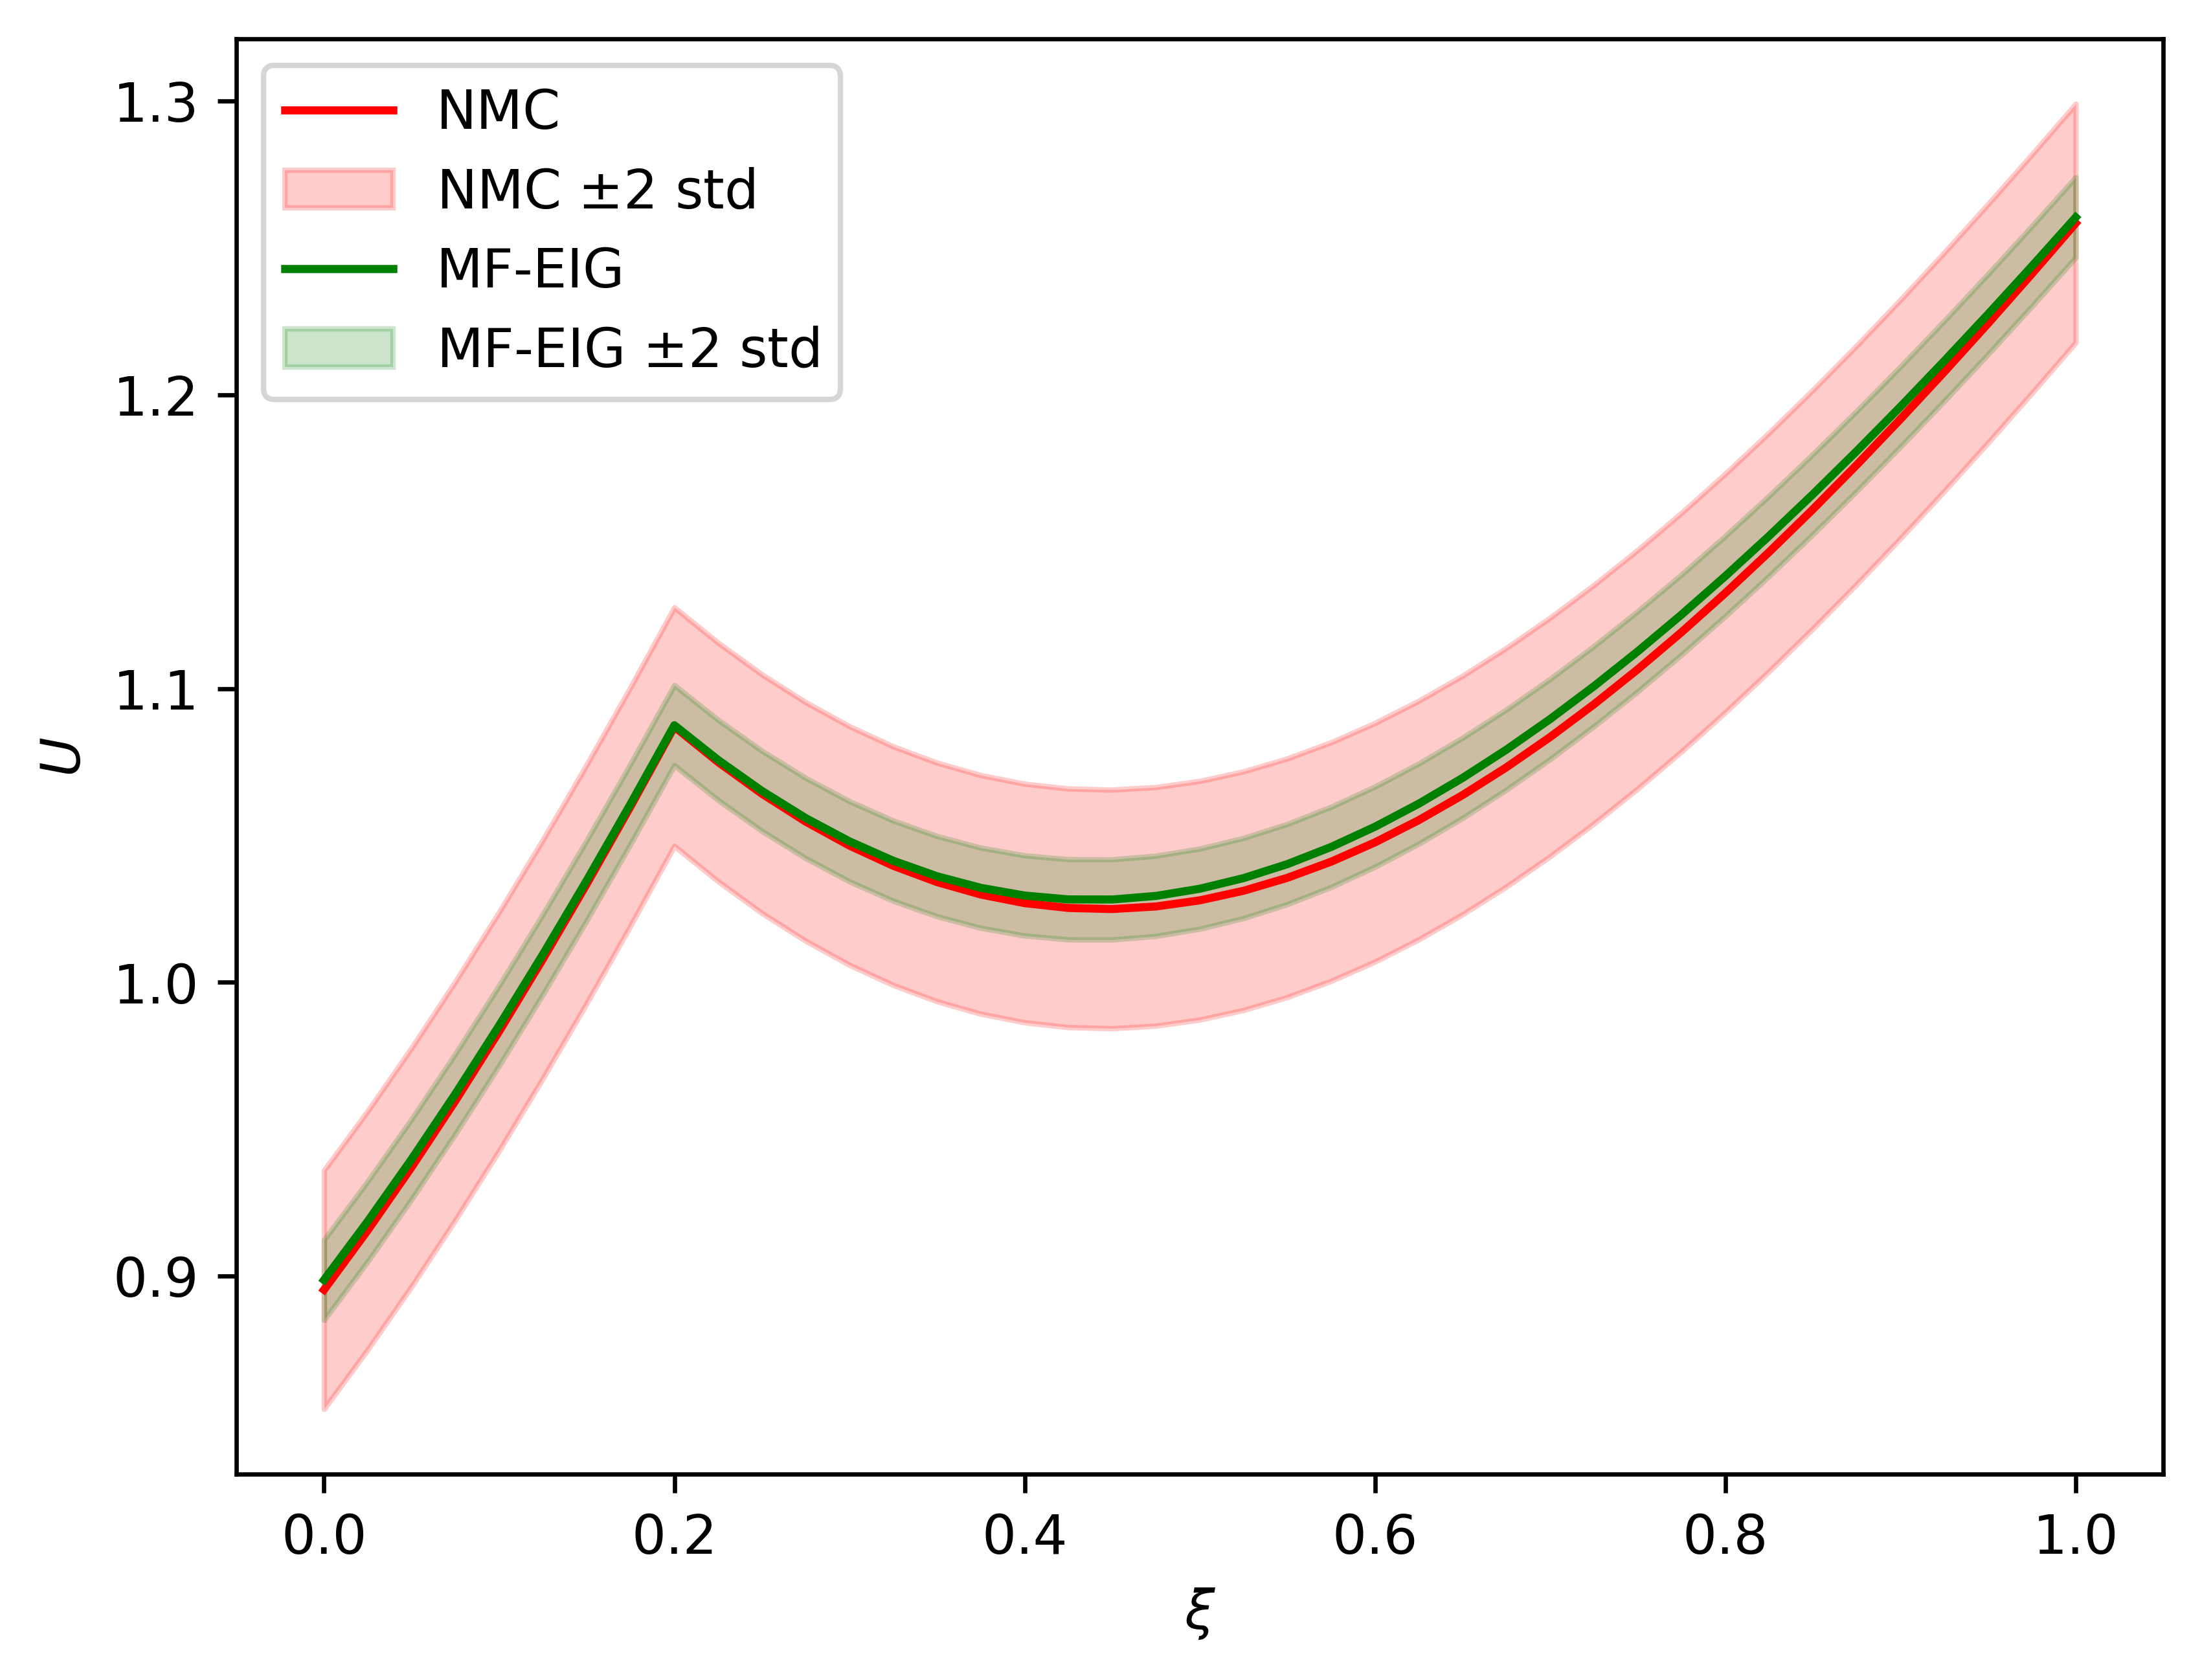

In [8]:
mf_eig_var = opt_result.variance

plt.rcParams['figure.dpi'] = 600
fig, ax = plt.subplots()
ax.plot(d_vals, u_d_nmc, color='red', label='NMC')
ax.fill_between(d_vals, u_d_nmc-2*np.sqrt(var_sf), u_d_nmc+np.sqrt(var_sf), color='red', alpha=0.2, label=r'NMC $\pm 2$ std')
ax.plot(d_vals, u_d, color='green', label='MF-EIG')
ax.fill_between(d_vals, u_d-2*np.sqrt(mf_eig_var), u_d+np.sqrt(mf_eig_var), color='green', alpha=0.2, label=r'MF-EIG $\pm 2$ std')
ax.set_xlabel(r'$\xi$')
ax.set_ylabel(r'$U$')
ax.legend()